<a href="https://colab.research.google.com/github/Developer-Abnam/100-Days-Of-ML-Code/blob/master/inventory_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Demand Forecasting using Machine Learning - Python

**Step 1: Importing Libraries and Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

**Step 2: Load and Explore the Dataset**

In [2]:
df = pd.read_csv('/content/train (1).csv')
print(df.head())
print(df.tail())

         date  store  item  sales
0  2013-01-01      1   1.0   13.0
1  2013-01-02      1   1.0   11.0
2  2013-01-03      1   1.0   14.0
3  2013-01-04      1   1.0   13.0
4  2013-01-05      1   1.0   10.0
              date  store  item  sales
500734  2014-02-15      5  28.0   51.0
500735  2014-02-16      5  28.0   60.0
500736  2014-02-17      5  28.0   34.0
500737  2014-02-18      5  28.0   36.0
500738  2014-02-19      5   NaN    NaN


In [3]:
df.shape

(500739, 4)

In [4]:
df.describe()

,store,item,sales
count,500739.000000,500738.000000,500738.000000
mean,5.455826,14.215786,54.099347
std,2.875866,7.918722,29.953233
min,1.000000,1.000000,0.000000
25%,3.000000,7.000000,30.000000
50%,5.000000,14.000000,49.000000
75%,8.000000,21.000000,72.000000
max,10.000000,28.000000,231.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500739 entries, 0 to 500738
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    500739 non-null  object 
 1   store   500739 non-null  int64  
 2   item    500738 non-null  float64
 3   sales   500738 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 15.3+ MB


**Step 3: Feature Engineering**

In [7]:
parts = df['date'].str.split("-", n = 3, expand=True)
df['year'] = parts[0].astype('int')
df['month'] = parts[1].astype('int')
df['day'] = parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1.0,13.0,2013,1,1
1,2013-01-02,1,1.0,11.0,2013,1,2
2,2013-01-03,1,1.0,14.0,2013,1,3
3,2013-01-04,1,1.0,13.0,2013,1,4
4,2013-01-05,1,1.0,10.0,2013,1,5


Whether it is a weekend or a weekday must have some effect on the requirements to fulfill the demands.

In [9]:
from datetime import datetime
def weekend_or_weekday(year, month, day):
  d = datetime(year, month, day)
  return 1 if d.weekday() > 4 else 0

df['weekend'] = df.apply(lambda x: weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1.0,13.0,2013,1,1,0
1,2013-01-02,1,1.0,11.0,2013,1,2,0
2,2013-01-03,1,1.0,14.0,2013,1,3,0
3,2013-01-04,1,1.0,13.0,2013,1,4,0
4,2013-01-05,1,1.0,10.0,2013,1,5,1


It would be nice to have a column which can indicate whether there was any holiday on a particular day or not.

In [10]:
from datetime import date
import holidays

india_holidays = holidays.country_holidays('IN')
df['holidays'] = df['date'].apply(lambda x: 1 if india_holidays.get(x) else 0)

Now, let's add some cyclical features.

In [11]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1.0,13.0,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1.0,11.0,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1.0,14.0,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1.0,13.0,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1.0,10.0,2013,1,5,1,0,0.5,0.866025


Let's have a column whose value indicates which day of the week it is.

In [13]:
def which_day(year, month, day):
  return datetime(year, month, day).weekday()
df['weekday'] = df.apply(lambda x: which_day(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1.0,13.0,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1.0,11.0,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1.0,14.0,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1.0,13.0,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1.0,10.0,2013,1,5,1,0,0.5,0.866025,5


In [14]:
df.drop('date', axis=1, inplace=True)
df.head()

,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,1,1.0,13.0,2013,1,1,0,0,0.5,0.866025,1
1,1,1.0,11.0,2013,1,2,0,0,0.5,0.866025,2
2,1,1.0,14.0,2013,1,3,0,0,0.5,0.866025,3
3,1,1.0,13.0,2013,1,4,0,0,0.5,0.866025,4
4,1,1.0,10.0,2013,1,5,1,0,0.5,0.866025,5


**Step 4: Exploratory Data Analysis**

In [15]:
df['store'].nunique(), df['item'].nunique()

(10, 28)

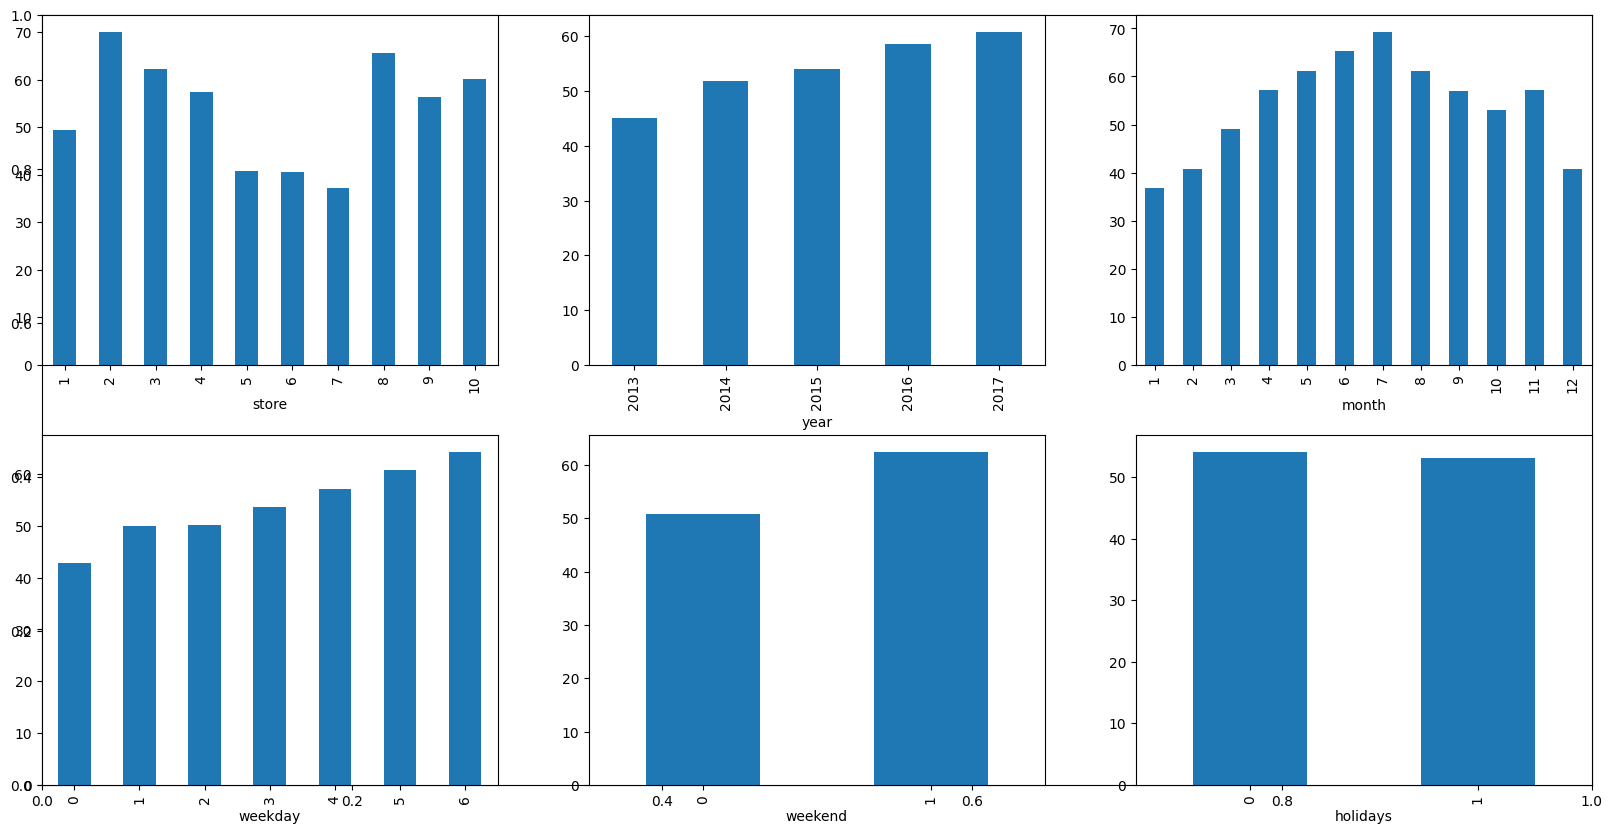

In [17]:
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
  plt.subplot(2, 3, i+1)
  df.groupby(col).mean()['sales'].plot.bar()
plt.show()

Now let's check the variation of stock as the month closes to the end using line plot.

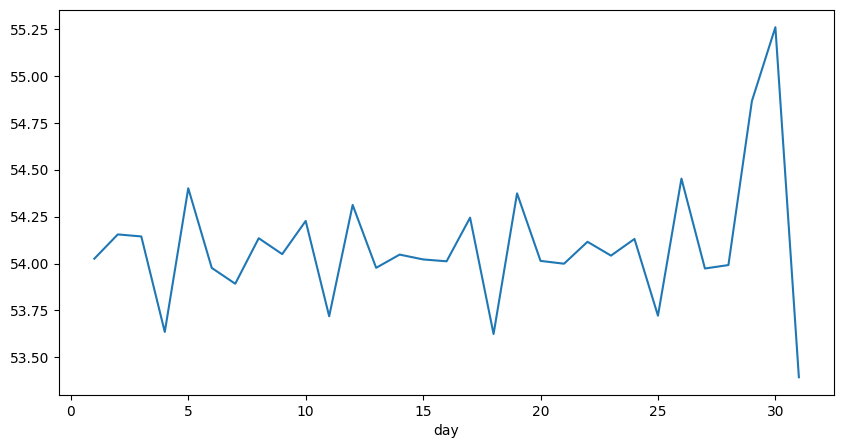

In [18]:
plt.figure(figsize=(10, 5))
df.groupby('day').mean()['sales'].plot()
plt.show()

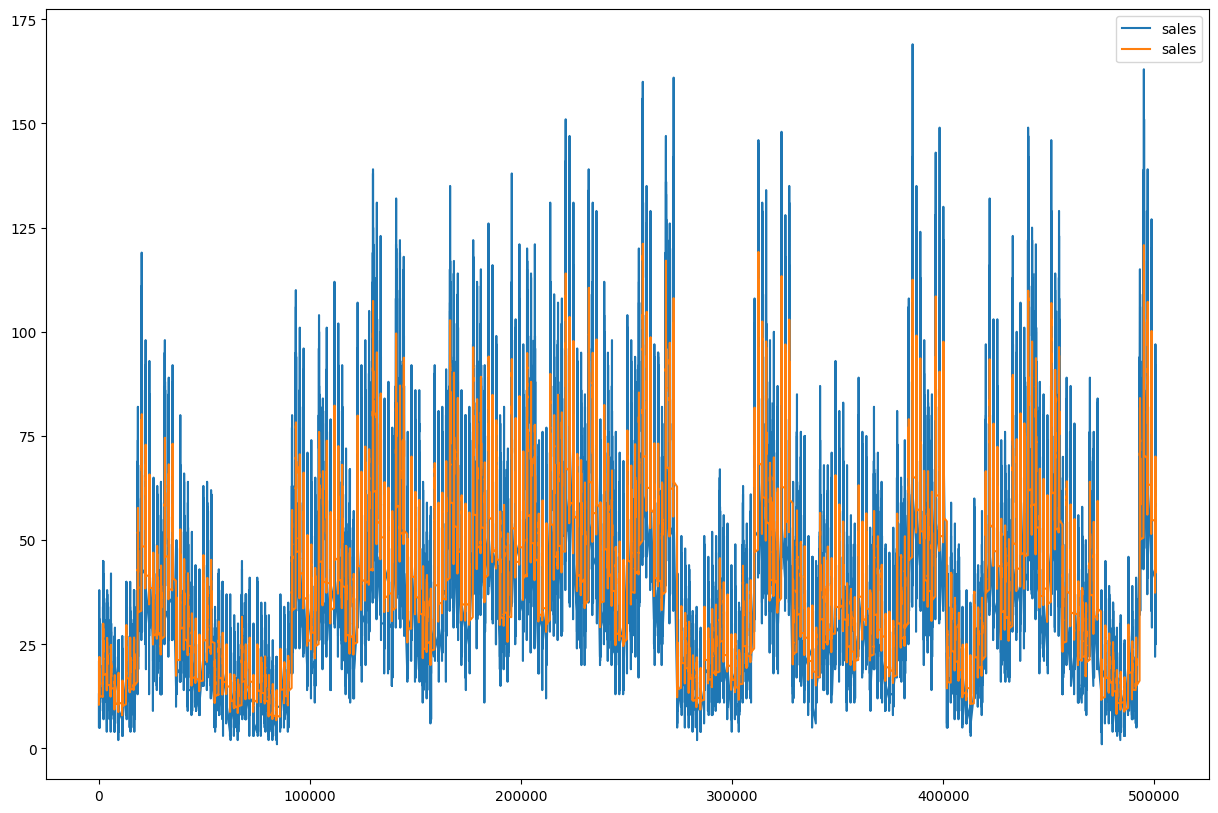

In [19]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

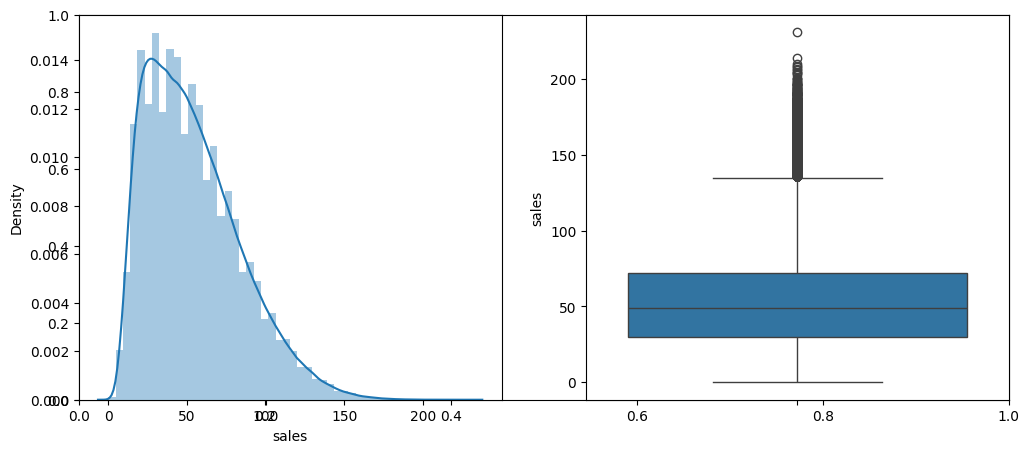

In [23]:
plt.subplots(figsize=(12, 5))
plt.subplot(1,2,1)
sb.distplot(df['sales'])

plt.subplot(1,2,2)
sb.boxplot(df['sales'])
plt.show()

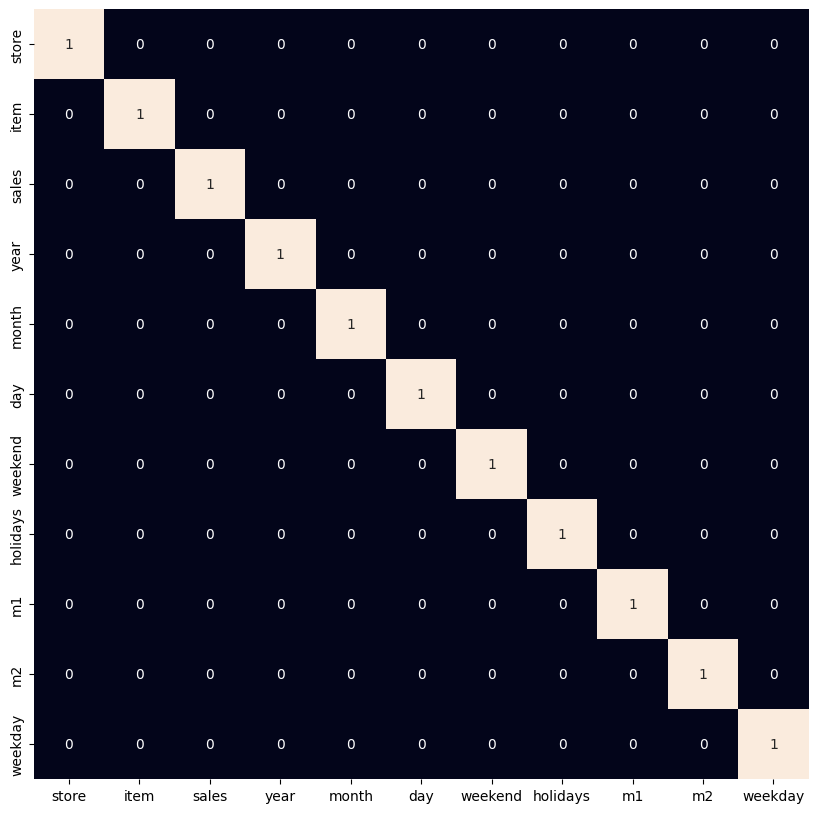

In [24]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

In [25]:
df = df[df['sales']<140]

**Step 5: Model Training**

In [26]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.05, random_state=42)
X_train.shape, X_val.shape

((471350, 9), (24808, 9))

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [30]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]
for i in range(4):
  models[i].fit(X_train, y_train)

  print(f'{models[i]}:')

  train_preds = models[i].predict(X_train)
  print('Training Error: ', mae(y_train, train_preds))

  val_preds = models[i].predict(X_val)
  print('Validation Error: ', mae(y_val, val_preds))
  print()

LinearRegression():
Training Error:  21.706145649849557
Validation Error:  21.70469839926597

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...):
Training Error:  6.750299905816128
Validation Error:  6.835431841727957

Lasso():
Training Error:  21.77928985452201
Validation Error:  21.780050607769002
